# <center>  GEOS3009/3909 – COASTAL ENVIRONMENTS AND PROCESSES

## <center>   PRACTICAL – PROCESSING WAVE DATA
    
<br>
<br>
<br>


### BACKGROUND – Wave analysis
<br>

<font size="3">
Processing and analysing wave data is an important skill. In this practical you are going to obtain
plots of power spectra for wave records. You are going learn how to enter and run python code and how to interpret your results, including the relative
importance of short and long waves.
<br>
    <br>
    
Spectral analysis is a technique that unravels the waves generated by different storms and describes
the complete distributions of wave energies and periods. Basically, the technique means to work
backward from the complexity of measured waves to determine the simple components whose
summation yields that complexity (Komar, 1998).


After completing this exercis you should be able to interpret some python code used to analyse wave data. You will
also learn about power spectra, you should be able to interpret relative energy levels and to identify
the frequency bands occupied by short waves and long waves.

Please refer to our lecture materials for more information on wave spectra.

</font>

![alt text](../data/images/instrument_deployment.png "Title")

<i> <center>                        Deploymentat Maroubra beach, ~0930h 16 April 2021 (Photo: Maleeka Barat)

### You're currently working in a Github Codespace and editing code in a Jupyter Notebook.

<b>  [What is a Github Codespace?](https://docs.github.com/en/codespaces/overview)

<b> [What is a Jupyter Notebook?](https://jupyterlab.readthedocs.io/en/stable/getting_started/overview.html)
    

### An example: visualizing data in the notebook ✨

Below is an example of a code cell. We'll visualize some simple data using two popular packages in Python. We'll use [NumPy](https://numpy.org/) to create some random data, and [Matplotlib](https://matplotlib.org) to visualize it.

Note how the code and the results of running the code are bundled together.


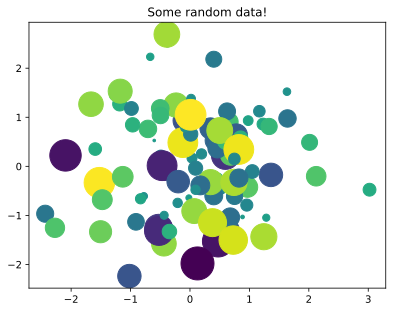

In [5]:
##### We can use '#' to create notes in the code. Please do this as you go.
##### As you can see below, it is very helpful when coding. 

# Import some libraries:
from matplotlib import pyplot as plt 
import numpy as np

# Generate 100 random data points along 3 dimensions
x, y, scale = np.random.randn(3, 100) # Here we use the numpy library
fig, ax = plt.subplots() # And here we use the matplotlib library

# Map each onto a scatterplot we'll create with Matplotlib
ax.scatter(x=x, y=y, c=scale, s=np.abs(scale)*500)
ax.set(title="Some random data!")
plt.show()

ok now lets look at some real data. 

## Part 1: Handling raw data

First we need to import some libraries. 

In [22]:
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

Here we set up some functions. We will use these later to plot and analyse the data. 

In [23]:
## The first function is going to plot pressure. 
def trim_time_interval(dataframe, start, end):
    
    trim_dataframe = dataframe[(dataframe.dates >= start) & (dataframe.dates <= end)]
    
    return trim_dataframe.copy()

Now we need to load the csv file. Lets look at the raw data.

In [24]:
csv_file = ('../data/prac2b_wavedata.csv')
data = pd.read_csv(csv_file)
print(data)

                          dates  pressure
0       2021-04-16 09:20:10.000   10.1907
1       2021-04-16 09:20:10.125   10.1906
2       2021-04-16 09:20:10.250   10.1907
3       2021-04-16 09:20:10.375   10.1907
4       2021-04-16 09:20:10.500   10.1909
...                         ...       ...
240364  2021-04-16 19:59:59.500   10.2094
240365  2021-04-16 19:59:59.625   10.2094
240366  2021-04-16 19:59:59.750   10.2095
240367  2021-04-16 19:59:59.875   10.2095
240368  2021-04-16 20:00:00.000   10.2095

[240369 rows x 2 columns]


So we have dates and pressure.

Lets have a look at the data we have loaded. We have loaded the data as a Pandas Dataframe which makes 2D data in python very simple:

In [25]:
data.head()


,dates,pressure
0,2021-04-16 09:20:10.000,10.1907
1,2021-04-16 09:20:10.125,10.1906
2,2021-04-16 09:20:10.250,10.1907
3,2021-04-16 09:20:10.375,10.1907
4,2021-04-16 09:20:10.500,10.1909


or the bottom rows:

In [26]:
data.tail()


,dates,pressure
240364,2021-04-16 19:59:59.500,10.2094
240365,2021-04-16 19:59:59.625,10.2094
240366,2021-04-16 19:59:59.750,10.2095
240367,2021-04-16 19:59:59.875,10.2095
240368,2021-04-16 20:00:00.000,10.2095


We need to check we have the right data types.
[What are python datatypes?](https://www.google.com/search?q=what+are+python+datatypes&rlz=1C1ONGR_en-GBAU967AU967&oq=what+are+python+datatypes&aqs=chrome.0.69i59j0i10i13i512l2j0i10i22i30l2j0i390l2.3183j0j7&sourceid=chrome&ie=UTF-8)

In [27]:
data.dtypes

dates        object
pressure    float64
dtype: object

We want our dates to be in datetime format. Here's how to convert:

In [28]:
# Conversion to datetime units
data['dates'] = pd.to_datetime(data['dates'], format='%Y/%m/%d %H:%M:%S.%f')

data.dtypes

dates       datetime64[ns]
pressure           float64
dtype: object

Lets plot the raw data and see what we have. 
To plot raw data quickly we are using [pandas.DataFrame.plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

<Axes: title={'center': 'All data from Maroubra and Malabar'}, xlabel='Dates', ylabel='Pressure (dbar)'>

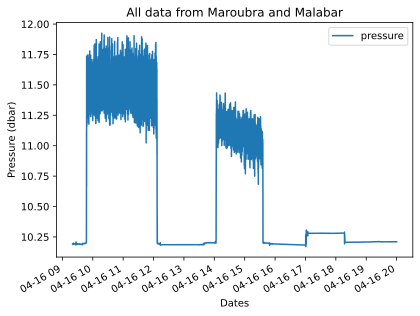

In [29]:
data.plot('dates', 'pressure',title='All data from Maroubra and Malabar', xlabel='Dates', ylabel='Pressure (dbar)')

#### Here we can see that the data is pretty ugly. 
We have pressure in dbar and we have some periods where the instrument is out of the water. The first deployment was at Maroubra, the second at Malabar, and the final deployment was when Ana washed them in a sink. The instruments were turned on and recording during this time. 
<br> We need to trim the data down to the times when it was submerged and measuring waves.
<br> From our field notes we have the start and end times of the instrument deployments.

In [32]:
# For Maroubra:
start_mar ='2021/04/16 10:30:00.00'
finish_mar = '2021/04/16 11:30:00.00'
mar_data = data[(data.dates >= start_mar) & (data.dates <= finish_mar)]

# And for malabar
start_mal = '2021/04/16 14:30:00.00'
finish_mal = '2021/04/16 15:30:00.00'
mal_data = data[(data.dates >= start_mal) & (data.dates <= finish_mal)]


<Axes: title={'center': 'change the title'}, xlabel='dates'>

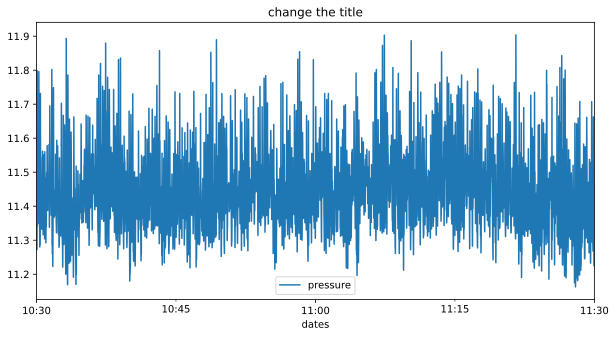

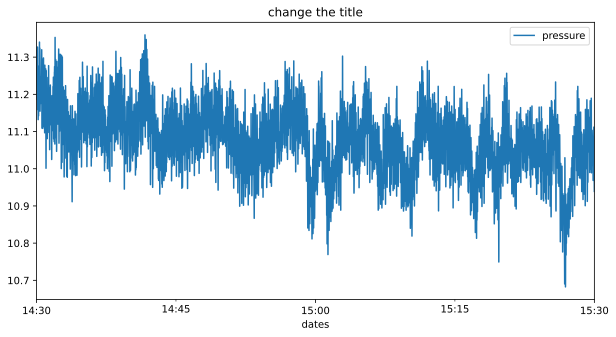

In [33]:
# Now plot the data
mar_data.plot('dates','pressure', figsize=(10,5), title = 'change the title')
mal_data.plot('dates','pressure', figsize=(10,5), title = 'change the title')

Lets save this data as CSVs and open them in another notebook. This is very easy:

In [34]:
mar_data.to_csv('..\data\maroubra_data.csv', index = False)
mal_data.to_csv('..\data\mal_data.csv', index = False)